In [104]:
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
from matplotlib.pyplot import gcf
import seaborn as sns
import scipy.stats
from scipy.stats import gaussian_kde
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy import stats
import urllib.request
import mdtraj as md
import scipy as sp
sns.set_style("darkgrid")

In [105]:
def get_chi1_angles(pdb):
        pdb = md.load_pdb(pdb)
        topology = pdb.topology
        table, bonds = topology.to_dataframe()
        ch1_pos, ch1_rad = md.compute_chi1(pdb)[0], md.compute_chi1(pdb)[1]
        chi_1_angles = np.degrees(ch1_rad)
        res = [table['resName'][ch1_pos[res][-1]] for res in range(len(ch1_pos))]
        n = [table['resSeq'][ch1_pos[res][-1]] for res in range(len(ch1_pos))]
        pos = [list(a) for a in zip(n,res)]
        return chi_1_angles, pos

def conv_to_np_arr_new(list_angles):
    mean_angles = np.array([])
    max_val = max(len(elem) for elem in list_angles)
    for i in range(len(list_angles)):
        len_ls = len(list_angles[i])
        if len_ls < max_val:
            arr_2nan = np.empty((1,max_val-len_ls))
            arr_2nan[:] = 0
            list_angles[i] = np.append(list_angles[i],arr_2nan)
    degs =  np.vstack((list_angles))
    av_sin = np.mean(np.sin(degs * np.pi / 180.),axis=0)
    av_cos = np.mean(np.cos(degs * np.pi / 180.),axis=0)
    mean_angles = np.rad2deg(np.arctan2(av_sin,av_cos))
    mean_angles[mean_angles <= -120] += 360
    return list_angles, mean_angles

def conv_to_np_arr_old(list_angles):
    max_val = max(len(elem) for elem in list_angles)
    for i in range(len(list_angles)):
        len_ls = len(list_angles[i])
        if len_ls < max_val:
            arr_2nan = np.empty((1,max_val-len_ls))
            arr_2nan[:] = 0
            list_angles[i] = np.append(list_angles[i],arr_2nan)
    return list_angles

# Correlation of Vector
def correlations_vector(score1, score2):
    # Declaring y and x to append mave_data comp_data, respectively.
    y=[]; x=[]
    # Looping through NaNs and inly appending non NaNs to y and x
    for i in range(score1.shape[0]):
        if np.isnan(score1[i]) or np.isnan(score2[i]):
            pass
        else:
            x.append(float(score1[i]))
            y.append(float(score2[i]))
    # Converting to np arrays and calculating pearson and spearman correalation.
    x=np.array(x)
    y=np.array(y)
    r=sp.stats.pearsonr(x,y)
    s,p=sp.stats.spearmanr(x,y)
    print("Pearson's correlation coefficient between data: ",abs(r[0]))
    print("Spearman's correlation coefficient bewteen data: " ,abs(s))

    return [abs(r[0]),abs(s)]

# Correlation of Matrix
def correlations_matrix(score1, score2):
    # Declaring y and x to append mave_data comp_data, respectively.
    y=[]; x=[]

    # Looping through NaNs and inly appending non NaNs to y and x
    for i in range(score1.shape[0]):
        for j in range(score1.shape[1]):
            if np.isnan(score1[i,j]) or np.isnan(score2[i,j]):
                pass
            else:
                x.append(float(score1[i,j]))
                y.append(float(score2[i,j]))
    # Converting to np arrays and calculating pearson and spearman correalation.
    x=np.array(x)
    y=np.array(y)
    r=sp.stats.pearsonr(x,y)
    s,p=sp.stats.spearmanr(x,y)
    print("Pearson's correlation coefficient between data: ",abs(r[0]))
    print("Spearman's correlation coefficient bewteen data: " ,abs(s))

    return [abs(r[0]),abs(s)]

# Load RMSDs from file
def load_rmsd(path, pdbs):
    dir_list = sorted(os.listdir(path))
    rmsd_list = np.zeros(len(dir_list))
    mut_list = [0]*len(dir_list)
    for i in range(len(dir_list)):
        df = pd.read_csv(path + dir_list[i])['rmsd'][0]
        rmsd_list[i] = df
        if 'af2' in path:
            df1 = pd.read_csv(path + dir_list[i])['mut'][0]
            mut_list[i] = df1
    return rmsd_list, mut_list

# Load torsion angles for PDBs
def compile_angles_pdb(path):
    filenames = list()
    dir_list = sorted(os.listdir(path))
    angles_list = list()
    pos_list = list()
    for i in range(1,len(dir_list)):
        chi1_angle, pos = get_chi1_angles(path + dir_list[i])
        chi1_angle = chi1_angle.squeeze()
        angles_list.append(chi1_angle)
        filenames.append(dir_list[i])
        pdb = md.load_pdb(path + dir_list[i])
        topology = pdb.topology
        table, bonds = topology.to_dataframe()
        pos_list.append(pos)
    return angles_list, filenames, pos_list

# Load torsion angles for af 2
def compile_angles_af2(path, pdbs):
    filenames = list()
    dir_list = sorted(os.listdir(path))
    angles_list = list()
    pos_list = list()
    plddt_list = list()
    for k in range(len(dir_list)):
        for pdb in pdbs:
            if pdb in dir_list[k]:
                tmp_dir_list = os.listdir(path + '/' + dir_list[k])    
                pdb_file = [file for file in  tmp_dir_list if 'rank_1' in file and '.pdb' in file]
                # Read pLDDT scores
                plddt_file = [file for file in  tmp_dir_list if 'rank_1' in file and '.json' in file]
                plddt_df = pd.read_json(path + '/' + dir_list[k] + '/' + plddt_file[0])
                plddt_ls = plddt_df['plddt'].tolist()
                plddt_list.append(plddt_ls)
                filenames.append(pdb_file[0])
                chi1_angle, pos = get_chi1_angles(path + '/' + dir_list[k] + '/' + pdb_file[0])
                chi1_angle = chi1_angle.squeeze()
                angles_list.append(chi1_angle)
                pos_list.append(pos)
    return angles_list, filenames, pos_list, plddt_list

def circ_meanscatter_plot(x_ls,y_ls, plddt):
    X, X_means = conv_to_np_arr_new(x_ls)
    Y, Y_means = conv_to_np_arr_new(y_ls)
    
    print(X_means.shape, Y_means.shape)
    
    #fig = plt.figure()
    plddt_mean = np.mean(plddt_indexed,axis=0)
    #kernel = gaussian_kde(plddt_mean)
    #kde = kernel.evaluate(plddt_mean)
    #norm = Normalize(vmin=kde.min(), vmax=kde.max())
    #colors = plt.cm.ScalarMappable(norm=norm, cmap='GnBu').to_rgba(kde)
    colormap = plt.cm.get_cmap('GnBu') # 'plasma' or 'viridis'
    colors = colormap(plddt_mean)    
    
    plt.title('P0A7Y4',fontsize=12)
    plt.xlabel('$\chi_1$ AF2 [$^\circ$]',fontsize=12)
    plt.ylabel('$\chi_1$ X-ray [$^\circ$]',fontsize=12)
    plt.xlim(-120,250)
    plt.ylim(-120,250)
    trend = np.polyfit(X_means,Y_means,1)
    trendpoly = np.poly1d(trend) 
    scatter_plot = plt.scatter(X_means, Y_means, vmin=0, vmax=X_means.max(), c=colors)
    sm = plt.cm.ScalarMappable(cmap=colormap)
    sm.set_clim(vmin=0, vmax=100)
    plt.colorbar(sm, label='pLDDT')
    plt.plot(X_means,trendpoly(X_means), c='black', label = 'ρ = 0.60')
    plt.legend(fontsize=14, loc="upper left")
    plt.savefig("/Users/holger/Desktop/master_thesis/notebooks/figs/chi1_plot_P0A7Y4_wt.pdf")
    
    print(X_means.shape, Y_means.shape)
    return correlations_vector(X_means, Y_means)

def scatter_plot(x_ls,y_ls):
    X=np.stack(conv_to_np_arr_old(x_ls))
    Y=np.stack(conv_to_np_arr_old(y_ls))
    print(np.nanmean(X, axis=0))
    values = np.vstack((np.nanmean(X, axis=0), np.nanmean(Y, axis=0)))
    kernel = gaussian_kde(values)
    kde = kernel.evaluate(values)
    norm = Normalize(vmin=kde.min(), vmax=kde.max())
    colors = cm.ScalarMappable(norm=norm, cmap='viridis_r').to_rgba(kde)
    plt.title('P0A7Y4',fontsize=12)
    plt.xlabel('$\chi_1$ AF2 [$^\circ$]',fontsize=12)
    plt.ylabel('$\chi_1$ X-ray [$^\circ$]',fontsize=12)

    trend = np.polyfit(np.nanmean(X, axis=0),np.nanmean(Y, axis=0),1)
    trendpoly = np.poly1d(trend) 
    plt.scatter(np.nanmean(X, axis=0), np.nanmean(Y, axis=0), c=colors)
    plt.plot(np.nanmean(X, axis=0),trendpoly(np.nanmean(X, axis=0)), c='black', label = 'ρ = 0.63')
    plt.legend(fontsize=14, loc="upper left")
    plt.savefig("/Users/holger/Desktop/master_thesis/notebooks/figs/chi1_plot_P0A7Y4.png", dpi=1200)
    
    return correlations_matrix(X, Y)

def mean_plddt(path, pdbs):
    filenames = list()
    dir_list = sorted(os.listdir(path))
    plddt_mean_ls = list()
    for k in range(len(dir_list)):
        for pdb in pdbs:
            if pdb in dir_list[k]:
                tmp_dir_list = os.listdir(path + '/' + dir_list[k])    
                pdb_file = [file for file in  tmp_dir_list if 'rank_1' in file and '.pdb' in file]
                # Read pLDDT scores
                plddt_file = [file for file in  tmp_dir_list if 'rank_1' in file and '.json' in file]
                print(plddt_file[0])
                plddt_df = pd.read_json(path + '/' + dir_list[k] + '/' + plddt_file[0])
                plddt_ls = plddt_df['plddt'].mean()
                plddt_mean_ls.append(plddt_ls)
                filenames.append(pdb_file[0])
    mean_arr = np.asarray(plddt_mean_ls)
    mean = np.mean(plddt_mean_ls)
    return mean

In [106]:
# Define consts
DATA_PATH_MUT_AF2 = '/Users/holger/Desktop/master_thesis/data/results_rmsd/results_rmsd_af2/results_rmsd_P0A7Y4_mut/'
DATA_PATH_MUT_PDB = '/Users/holger/Desktop/master_thesis/data/results_rmsd/results_rmsd_pdb/results_rmsd_P0A7Y4_mut/'
DATA_PATH_PDB = '/Users/holger/Desktop/master_thesis/data/arodz12/pdbs_P0A7Y4/'
DATA_PATH_PDB_WT= '/Users/holger/Desktop/master_thesis/data/arodz12/pdbs_wt_P0A7Y4/'

DATA_PATH_AF2 = '/Users/holger/Desktop/master_thesis/data/results_af2/P0A7Y4/'
arodz_pdbs = ['1gob', '1kva', '1kvb', '1lav', '1law', '1rbr', '1rbs', '1rbt','1rbu', '1rbv', '1rda', '1rdb']

DATA_PATH_MUT_2_MUT = '/Users/holger/Desktop/master_thesis/data/results_rmsd/results_rmsd_af2/results_rmsd_P0A7Y4_mut2mut/'
DATA_PATH_MUT_2_WT = '/Users/holger/Desktop/master_thesis/data/results_rmsd/results_rmsd_af2/results_rmsd_P0A7Y4_mut2wt/'

mut_2_mut_rmsd_list, mut = load_rmsd(DATA_PATH_MUT_2_MUT, arodz_pdbs)
mut_2_wt_rmsd_list, mut = load_rmsd(DATA_PATH_MUT_2_WT, arodz_pdbs)

# Get RMSDs
af2_rmsd_list, mut = load_rmsd(DATA_PATH_MUT_AF2, arodz_pdbs)
pdb_rmsd_list, _ = load_rmsd(DATA_PATH_MUT_PDB, arodz_pdbs)

# Get chi 1 angles
chi_1_pdb, filenames_pdb, pos_pdb = compile_angles_pdb(DATA_PATH_PDB)
chi_1_af2, filenames_af2, pos_af2, plddt = compile_angles_af2(DATA_PATH_AF2,arodz_pdbs)

chi_1_pdb_wt, filenames_pdb_wt, pos_pdb_wt = compile_angles_pdb(DATA_PATH_PDB_WT)
chi_1_pdb_wt_ls = []
for i in range(len(chi_1_pdb_wt)):
    if len(chi_1_pdb_wt[i]) == 127:
        chi_1_pdb_wt_ls.append(chi_1_pdb_wt[i][0:127])


In [107]:
mean_plddt_r = mean_plddt(DATA_PATH_AF2,arodz_pdbs)

P0A7Y4_1gob_517f1_unrelaxed_rank_1_model_1_scores.json
P0A7Y4_1kva_4963a_unrelaxed_rank_1_model_1_scores.json
P0A7Y4_1kvb_90ba3_unrelaxed_rank_1_model_2_scores.json
P0A7Y4_1lav_2d3cf_unrelaxed_rank_1_model_2_scores.json
P0A7Y4_1law_ba939_unrelaxed_rank_1_model_3_scores.json
P0A7Y4_1rbr_b743d_unrelaxed_rank_1_model_1_scores.json
P0A7Y4_1rbs_d5711_unrelaxed_rank_1_model_1_scores.json
P0A7Y4_1rbt_843d9_unrelaxed_rank_1_model_1_scores.json
P0A7Y4_1rbu_8a014_unrelaxed_rank_1_model_1_scores.json
P0A7Y4_1rbv_0d4c4_unrelaxed_rank_1_model_2_scores.json
P0A7Y4_1rda_dd370_unrelaxed_rank_1_model_3_scores.json
P0A7Y4_1rdb_9f9f5_unrelaxed_rank_1_model_1_scores.json


In [110]:
round(mean_plddt_r,3)
pdb_rmsd_list[pdb_rmsd_list > 0.3]

array([1.56183275])

Pearson's correlation coefficient between data:  0.972812015564513
Spearman's correlation coefficient bewteen data:  0.9860139860139862


[0.972812015564513, 0.9860139860139862]

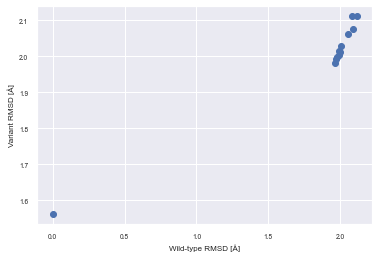

In [92]:
# RMSD plot: AF2 vs. PDB
plt.ylabel('Variant RMSD [Å]',fontsize=8)
plt.xlabel('Wild-type RMSD [Å]',fontsize=8)

plt.scatter(mut_2_wt_rmsd_list, mut_2_mut_rmsd_list)
#plt.xlim(0.3,0.75)
#plt.ylim(0.3,0.75)
plt.savefig("/Users/holger/Desktop/master_thesis/notebooks/figs/P0A7Y4_dis_scatter.png", dpi=1200)
correlations_vector(mut_2_wt_rmsd_list, mut_2_mut_rmsd_list)

["['G77A']", "['D134A']", "['D134H']", "['V74L']", "['V74I']", "['H62P']", "['H62A']", "['K95G']", "['K95N']", "['K95A']", "['D10N']", "['E48Q']"]
2
Pearson's correlation coefficient between data:  0.9879901587559119
Spearman's correlation coefficient bewteen data:  0.7142857142857144


[0.9879901587559119, 0.7142857142857144]

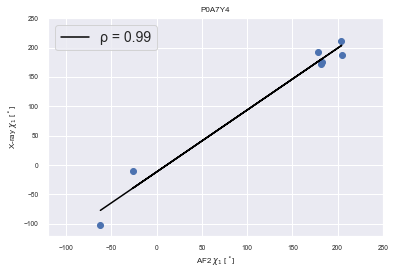

In [93]:
chi_1_af2_mean = []
chi_1_pdb_mean = []
rsn_N = list()
for i in range(len(filenames_af2)):
    rsn_N.append(mut[i])
    chi_1_af2_mean.append(np.mean(chi_1_af2[i]))
    chi_1_pdb_mean.append(np.mean(chi_1_pdb[i]))

print(rsn_N)
for i in range(len(pos_af2[2])):
    if pos_af2[11][i][0] == int(rsn_N[2][3:-3]):
        print(2)
        
chi_1_mut_af2 = np.asarray([chi_1_af2[2][110],chi_1_af2[3][110],chi_1_af2[4][110],chi_1_af2[5][47],chi_1_af2[8][77],chi_1_af2[10][9],chi_1_af2[11][37]], dtype=np.float32)

chi_1_mut_pdb = np.asarray([chi_1_pdb[2][110],chi_1_pdb[3][110],chi_1_pdb[4][110],chi_1_pdb[5][47],chi_1_pdb[8][77],chi_1_pdb[10][9],chi_1_pdb[11][37]], dtype=np.float32)

chi_1_mut_af2[chi_1_mut_af2 <= -120] += 360
chi_1_mut_pdb[chi_1_mut_pdb <= -120] += 360

plt.title('P0A7Y4',fontsize=8)
plt.ylabel('X-ray $\chi_1$ [$^\circ$]',fontsize=8)
plt.xlabel('AF2 $\chi_1$ [$^\circ$]',fontsize=8)
trend = np.polyfit(chi_1_mut_af2,chi_1_mut_pdb,1)
trendpoly = np.poly1d(trend) 
plt.scatter(chi_1_mut_af2, chi_1_mut_pdb)
plt.xlim(-120,250)
plt.ylim(-120,250)
plt.plot(chi_1_mut_af2,trendpoly(chi_1_mut_af2), c='black', label = 'ρ = 0.99')
plt.legend(fontsize=14, )
plt.savefig('/Users/holger/Desktop/master_thesis/notebooks/figs/chi1_mut_P0A7Y4.png', dpi=1200, bbox_inches = 'tight')

correlations_vector(np.array(chi_1_mut_af2),np.array(chi_1_mut_pdb))

In [94]:
# Do this for all
plddt_idx = list()
for i in range(len(pos_af2)):
    tmp = np.asarray([pos_af2[0][i][0] for i in range(len(pos_af2[0]))])
    plddt_idx.append(tmp)
plddt_idx = np.vstack(np.asarray(plddt_idx)-1)
plddt = np.asarray(plddt)
plddt_indexed = [plddt[i][plddt_idx[i]] for i in range(len(plddt))]

plddt_indexed = np.vstack(plddt_indexed)

plddt_indexed.shape

(12, 127)

(127,) (127,)
(127,) (127,)
Pearson's correlation coefficient between data:  0.5966306907640657
Spearman's correlation coefficient bewteen data:  0.5280921916010498


/var/folders/38/bl4yf01j4jx6h6m2ctkbjd3r0000gn/T/ipykernel_2619/536537155.py:161: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sm, label='pLDDT')


[0.5966306907640657, 0.5280921916010498]

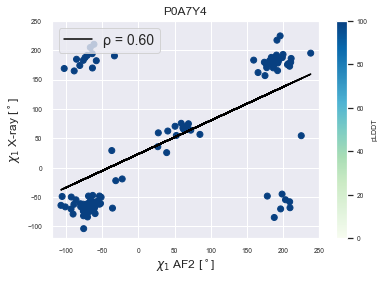

In [95]:
# Scatter plot chi_1_af2 vs. chi_1_pdb
#circ_meanscatter_plot(chi_1_af2, chi_1_pdb,plddt)
circ_meanscatter_plot(chi_1_af2,chi_1_pdb_wt_ls, plddt)

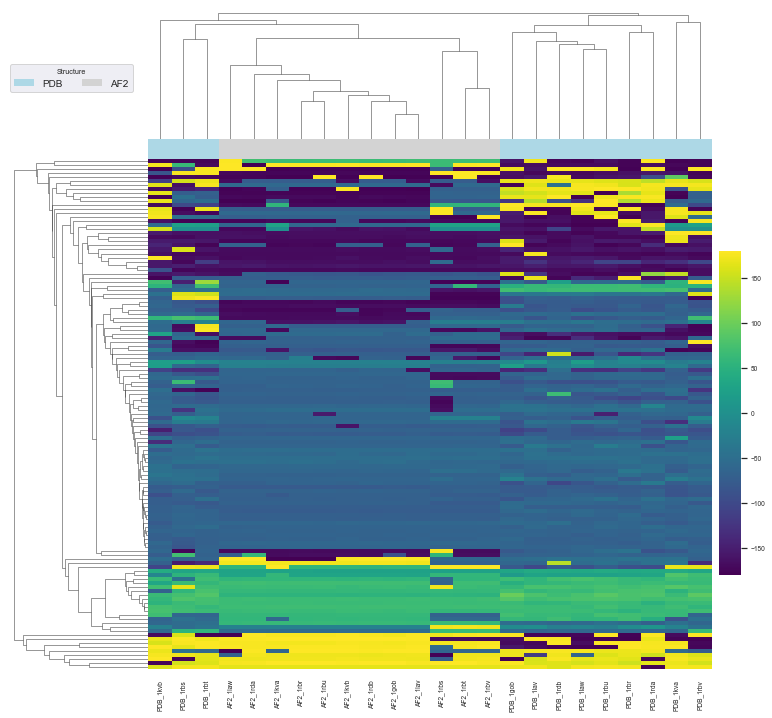

In [96]:
X=np.stack(conv_to_np_arr_old(chi_1_af2)).reshape(-1,127)
Y=np.stack(conv_to_np_arr_old(chi_1_pdb)).reshape(-1,127)

dat = np.vstack((Y,X)).T
filenames_combined = filenames_pdb+filenames_af2
names = filenames_combined

filenames_combined = ["AF2_" + name[7:11] if name.startswith("P0A7Y4") else "PDB_"+ name[0:4] for name in names]
df_test = pd.DataFrame(dat, index=[i for i in range(127)], columns=filenames_combined)


dataset = ["AF2" if name.startswith("P0A7Y4") else "PDB" for name in names]
a = {'AF2': 'lightgray', 'PDB': 'lightblue'}
colors = lambda x: a[x]
row_colors = list(map(colors, dataset))
sns.set(font_scale = 0.60)
cm=sns.clustermap(df_test,
               method='average',
               cbar_pos = (1, .20, .03, .45),#(0.02, 0.83, 0.05, 0.18),
               yticklabels=False,
               col_colors=row_colors,
               xticklabels=True,
               #standard_scale=1,
               annot_kws={"size": 1},
               cmap='viridis')
# Add legends
for label in ['PDB', 'AF2']:
    cm.ax_col_dendrogram.bar(0, 0, color=a[label], label=label, linewidth=0);
l1 = cm.ax_col_dendrogram.legend(title='Structure', loc="center", ncol=5, bbox_to_anchor=(0.1, 0.89), bbox_transform=gcf().transFigure, prop={'size': 10})


plt.savefig('/Users/holger/Desktop/master_thesis/notebooks/figs/clustermap_chi1_P0A7Y4.png', dpi=1200, bbox_inches = 'tight')

[0.09601104 0.09601104 0.09601104 0.09601104 0.09601104 0.09601104
 0.09601104 0.09601104 0.09601104 0.09601104 0.09601104 0.09601104] [0.28203595 0.26094441 1.56183275 0.16402749 0.16594242 0.19799246
 0.19170109 0.1565245  0.16933303 0.1321985  0.22882151 0.20662069]
Pearson's correlation coefficient between data:  0.429006542370027
Spearman's correlation coefficient bewteen data:  0.4833632631534589


/Users/holger/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4053: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


[0.429006542370027, 0.4833632631534589]

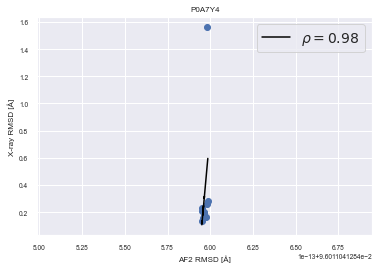

In [97]:
print(af2_rmsd_list,pdb_rmsd_list)
# RMSD plot: AF2 vs. PDB
plt.title('P0A7Y4',fontsize=8)
plt.ylabel('X-ray RMSD [Å]',fontsize=8)
plt.xlabel('AF2 RMSD [Å]',fontsize=8)
trend = np.polyfit(af2_rmsd_list,pdb_rmsd_list,1)
trendpoly = np.poly1d(trend) 
plt.scatter(af2_rmsd_list, pdb_rmsd_list)
plt.plot(af2_rmsd_list,trendpoly(af2_rmsd_list), c='black', label = r'$\rho = 0.98$')
plt.legend(fontsize=14)
plt.savefig('/Users/holger/Desktop/master_thesis/notebooks/figs/rmsd_P0A7Y4.png', dpi=1200, bbox_inches = 'tight')
correlations_vector(af2_rmsd_list, pdb_rmsd_list)

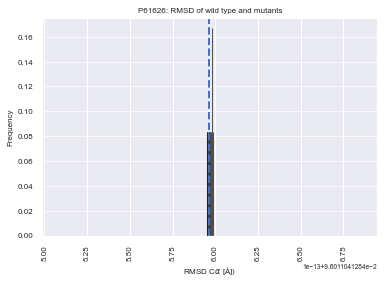

In [98]:
# Create histogram of RMSDs
output_variance_np = np.asarray(af2_rmsd_list)
hist,bin_edges = np.histogram(af2_rmsd_list)
weights = np.ones_like(af2_rmsd_list) / len(af2_rmsd_list)
n, bins, patches = plt.hist(af2_rmsd_list, 50, weights = weights, facecolor='lightblue', edgecolor='k', alpha=0.75)
plt.grid(axis='y', alpha=0.75)
plt.xlabel(r'RMSD C$\alpha$ [Å])',fontsize=8)
plt.ylabel('Frequency',fontsize=8)
plt.xticks(fontsize=8,rotation='vertical')
plt.yticks(fontsize=8)
plt.ylabel('Frequency',fontsize=8)
plt.title('P61626: RMSD of wild type and mutants',fontsize=8)
plt.axvline(np.mean(af2_rmsd_list), color='b', linestyle='dashed', linewidth=2)
#plt.savefig('/Users/holgerchristiannyelandehlers/Desktop/master_thesis/notebooks/figs/rmsd_dis_P0A7Y4.png', dpi=1200)

In [99]:
# Concat dataframes
df_af2 = pd.DataFrame (af2_rmsd_list, columns = ['rmsd_af2'])
df_pdb = pd.DataFrame (pdb_rmsd_list, columns = ['rmsd_pdb'])
df_mut2mut = pd.DataFrame (mut_2_mut_rmsd_list, columns = ['rmsd'])
df_mut2wt = pd.DataFrame (mut_2_wt_rmsd_list, columns = ['rmsd'])
df_concated = pd.concat([df_af2, df_pdb], axis=1)
a = dict(zip(np.unique(df_concated.rmsd_af2), np.array(['g','skyblue'])))
#df_concated.describe()

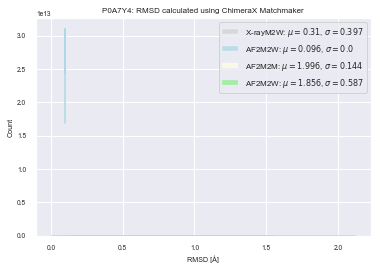

In [100]:
sns.histplot(df_pdb,x="rmsd_pdb", binwidth=0.01, alpha=0.75, kde=True, color="lightgrey", label="X-rayM2W: $\mu = {}$, $\sigma = {}$".format(round(df_pdb["rmsd_pdb"].mean(),3),round(df_pdb["rmsd_pdb"].std(),3)))
sns.histplot(df_af2, x="rmsd_af2", binwidth=0.01, alpha=0.75, kde=True, color='lightblue', label="AF2M2W: $\mu = {}$, $\sigma = {}$".format(round(df_af2["rmsd_af2"].mean(),3),round(df_af2["rmsd_af2"].std(),3)))
sns.histplot(df_mut2mut,x="rmsd", binwidth=0.01, alpha=0.75, kde=True, color="lightyellow", label="AF2M2M: $\mu = {}$, $\sigma = {}$".format(round(df_mut2mut["rmsd"].mean(),3),round(df_mut2mut["rmsd"].std(),3)))
sns.histplot(df_mut2wt, x="rmsd", binwidth=0.01, alpha=0.75, kde=True, color='lightgreen', label="AF2M2W: $\mu = {}$, $\sigma = {}$".format(round(df_mut2wt["rmsd"].mean(),3),round(df_mut2wt["rmsd"].std(),3)))

plt.legend(fontsize=8)
plt.title('P0A7Y4: RMSD calculated using ChimeraX Matchmaker',fontsize=8)

plt.xlabel("RMSD [Å]")
plt.ylabel("Count")
plt.savefig("/Users/holger/Desktop/master_thesis/notebooks/figs/P0A7Y4_dis.pdf")
plt.show()

In [101]:
df_af2["rmsd_af2"].mean(), df_af2["rmsd_af2"].std()
df_pdb['rmsd_pdb'].mean()

0.3098312341382036

In [102]:
print(df_af2["rmsd_af2"].mean())
print(df_pdb['rmsd_pdb'].mean())

0.09601104128459664
0.3098312341382036


In [103]:
df_af2

,rmsd_af2
0,0.096011
1,0.096011
2,0.096011
3,0.096011
4,0.096011
5,0.096011
6,0.096011
7,0.096011
8,0.096011
9,0.096011
